# Cohort Analysis

We would like to perform a cohort analysis on our customers to help identify changes in ordering behavior based on their signup date.
For this exercise group the customers into week long (7 days) cohorts and then calculate how many distinct customers ordered within X days from their signup date, where X is a multiple of 7. Older cohorts will have more buckets: 0-6 days, 7-13 days, 14-20 days, etc.

You may write your solution in the language of your choice, but we do have a preference towards Python (preferably using 3.6 or 3.7 with type hints). Please provide a README with clear instructions on how to setup any dependencies and execute your program or Jupyter notebook.  The program should output an HTML table or CSV in a format similar to:

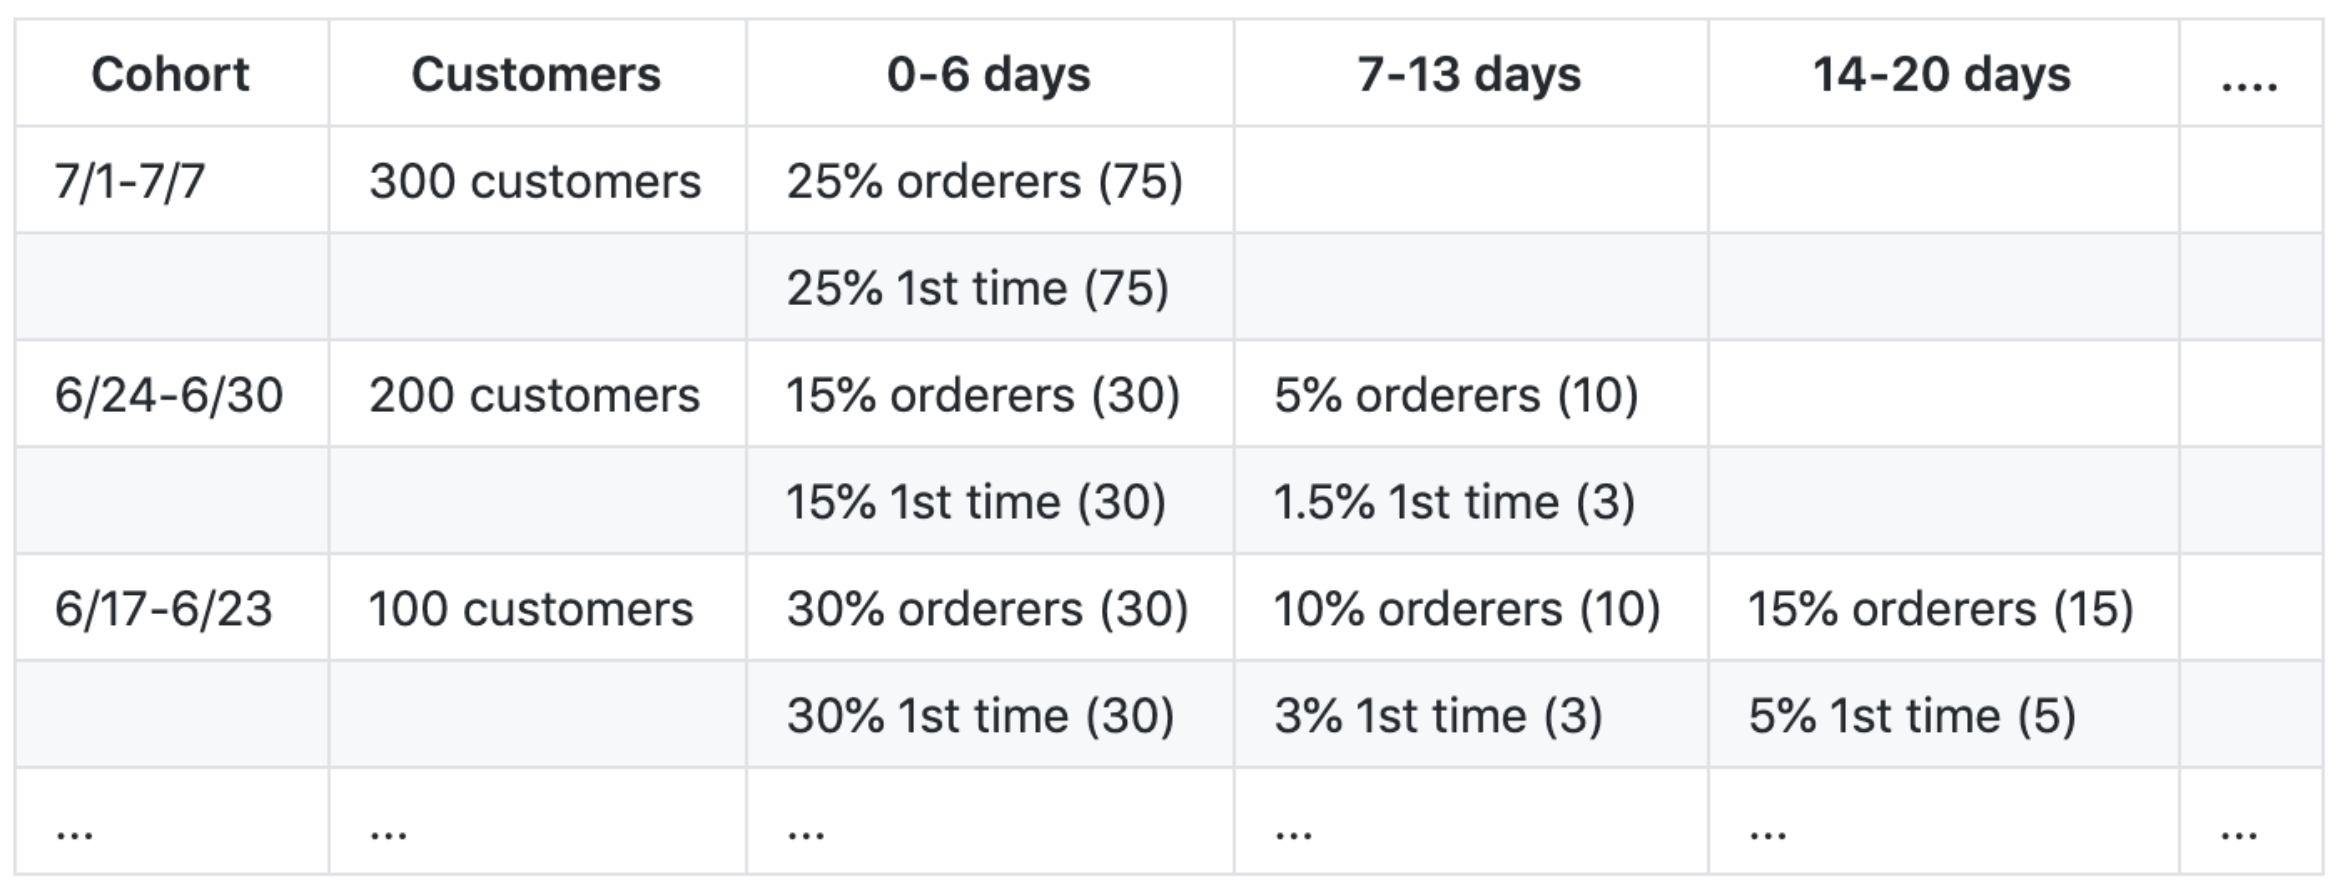


Please also include one plot created from the data set output and give a small description of what the plot displays.

The program should read the data from both customers.csv and orders.csv and calculate at least 8 weeks of cohorts. All dates are stored in UTC but grouping should be handled in a configurable timezone (ex: PDT). 
After a few submissions that were clearly simple adaptations of Greg Reda's blog post "Cohort Analysis with Python" we are asking submitters to not use guides or examples when doing this exercise and to solve the problem on their own. However, information about what a cohort analysis is and how it is used (ex: http://www.cohortanalysis.com/ ) is completely fine.


### Import libraries

In [136]:
import pandas as pd
import numpy as np

### Import data

In [4]:
customers = pd.read_csv('customers.csv')
orders = pd.read_csv('orders.csv')

In [16]:
print('customers file: {}'.format(customers.shape))
customers.head()

customers file: (25716, 2)


,id,created
0,35410,2015-07-03 22:01:11
1,35417,2015-07-03 22:11:23
2,35412,2015-07-03 22:02:52
3,35413,2015-07-03 22:05:02
4,35424,2015-07-03 22:21:55


In [12]:
print('orders file: {}'.format(orders.shape))
orders.head()

orders file: (27575, 4)


,id,order_number,user_id,created
0,1709,36,344,2014-10-28 00:20:01
1,1406,7,608,2014-10-14 23:44:53
2,1716,6,2296,2014-10-28 17:47:07
3,1426,2,1225,2014-10-15 18:33:38
4,1415,6,797,2014-10-15 02:07:16


Check for missing values.

In [61]:
print('==='*30)
print('Number of missing values in customers table: \n{}'.format(customers.isnull().sum()))
print('==='*30)
print('Number of missing values in orders table: \n{}'.format(orders.isnull().sum()))
print('==='*30)

Number of missing values in customers table: 
id         0
created    0
dtype: int64
Number of missing values in orders table: 
id              0
order_number    0
user_id         0
created         0
dtype: int64


There is no missing value in any of tables, so merging is straightforward.

### Merge
Merge **orders** and **customers** tables.  
Use id column from customers and user_id from orders as foreign key.  
Use 'outer' join to keep all the customers (including the ones that did not order or the ones who ordered but do not have their information in customers table) in the merged table. 

In [62]:
custm_ordrs = customers.merge(orders, how = 'outer', left_on = 'id', right_on = 'user_id', suffixes = ('_custm', '_ordrs'))

In [63]:
print('Size after merge: {}'.format(custm_ordrs.shape))
custm_ordrs.head()

Size after merge: (47935, 6)


,id_custm,created_custm,id_ordrs,order_number,user_id,created_ordrs
0,35410.0,2015-07-03 22:01:11,NaN,NaN,NaN,NaN
1,35417.0,2015-07-03 22:11:23,NaN,NaN,NaN,NaN
2,35412.0,2015-07-03 22:02:52,NaN,NaN,NaN,NaN
3,35413.0,2015-07-03 22:05:02,NaN,NaN,NaN,NaN
4,35424.0,2015-07-03 22:21:55,27970.0,1.0,35424.0,2015-07-03 23:37:49


Check for missing values in the merge.

In [69]:
custm_ordrs.isna().sum()

id_custm         10560
created_custm    10560
id_ordrs         20360
order_number     20360
user_id          20360
created_ordrs    20360
dtype: int64

This shows there are rows where id_custm or user_id are missing.  
Lets capture and display some of them.

In [70]:
# Example rows with missing 'id_custm':
custm_ordrs.loc[custm_ordrs['id_custm'].isnull()][:3]

,id_custm,created_custm,id_ordrs,order_number,user_id,created_ordrs
37375,NaN,NaN,1709.0,36.0,344.0,2014-10-28 00:20:01
37376,NaN,NaN,1747.0,37.0,344.0,2014-10-29 03:42:18
37377,NaN,NaN,1827.0,38.0,344.0,2014-11-02 03:36:30


This example shows the customer with user_id=344 has ordered for multiple times but his/her information is missing in customers table (no id_custm or created_custom data).  
It is easy to impute the 'id_custm' values for these users by copying the value from 'user_id' column. But how to impute the 'created_custm' values for these users?  We have the data for when they put an order, but no data for when did they jouin us. In other words how can we know when did these customers joined us? 

Lets first impute the missing 'id_custm' column for these customers:

In [76]:
custm_ordrs.loc[custm_ordrs['id_custm'].isnull() & ~custm_ordrs['user_id'].isnull(), 'id_custm'] = custm_ordrs.loc[custm_ordrs['id_custm'].isnull() & ~custm_ordrs['user_id'].isnull(), 'user_id']

In [77]:
custm_ordrs.isna().sum()

id_custm             0
created_custm    10560
id_ordrs         20360
order_number     20360
user_id          20360
created_ordrs    20360
dtype: int64

In [78]:
custm_ordrs.loc[custm_ordrs['created_custm'].isnull()][:3]

,id_custm,created_custm,id_ordrs,order_number,user_id,created_ordrs
37375,344.0,NaN,1709.0,36.0,344.0,2014-10-28 00:20:01
37376,344.0,NaN,1747.0,37.0,344.0,2014-10-29 03:42:18
37377,344.0,NaN,1827.0,38.0,344.0,2014-11-02 03:36:30


This shows those customers with missing data on their 'join date'. There are 10,560 such data points. How to impute this data?  


There are also rows where 'user_id' column is missing. Lets display some examples:

In [85]:
# Example rows with missing 'user_id':
custm_ordrs.loc[~custm_ordrs['id_custm'].isnull() & custm_ordrs['user_id'].isnull()][:3]

,id_custm,created_custm,id_ordrs,order_number,user_id,created_ordrs
0,35410.0,2015-07-03 22:01:11,NaN,NaN,NaN,NaN
1,35417.0,2015-07-03 22:11:23,NaN,NaN,NaN,NaN
2,35412.0,2015-07-03 22:02:52,NaN,NaN,NaN,NaN


This shows that for example custumer with id=35410 has joined us, but never put an order, or the order information is missing. I **assume** that these customers have never put an order. 

### Missing data, summary:
There are two types of missing data:
1. Customers where we know when did they join us, but missing 'order' data
2. Customers where we have 'order' data, but missing information about when did they join us.

I will leave the data in for type 1 customers. For type 2 customers there are at least two methods to deal with them:
- Elimination from the dataset
- Making some assumption about the date they joined us (e.g. assuming that the join date is equal to the date of the first order)

Since the cohort analysis is based on the data about when the customers joined us, I decided to eliminate type 2 customers, instead of assuming/guessing a 'join date' for them. 

As a result I merge the original two tables (customers and orders) again, but using 'left' join instead of 'outer' join. This will keep only the customers with existing 'join date' data:


### Merge   
This time use 'left' join instead of 'outer' join:

In [86]:
custm_ordrs = customers.merge(orders, how = 'left', left_on = 'id', right_on = 'user_id', suffixes = ('_custm', '_ordrs'))

In [87]:
print('Size after merge: {}'.format(custm_ordrs.shape))
custm_ordrs.head()

Size after merge: (37375, 6)


,id_custm,created_custm,id_ordrs,order_number,user_id,created_ordrs
0,35410,2015-07-03 22:01:11,NaN,NaN,NaN,NaN
1,35417,2015-07-03 22:11:23,NaN,NaN,NaN,NaN
2,35412,2015-07-03 22:02:52,NaN,NaN,NaN,NaN
3,35413,2015-07-03 22:05:02,NaN,NaN,NaN,NaN
4,35424,2015-07-03 22:21:55,27970.0,1.0,35424.0,2015-07-03 23:37:49


The 'user_id' column is redundant, remove it.

In [91]:
custm_ordrs.drop(labels='user_id', axis = 1, inplace = True)
custm_ordrs.head()

,id_custm,created_custm,id_ordrs,order_number,created_ordrs
0,35410,2015-07-03 22:01:11,NaN,NaN,NaN
1,35417,2015-07-03 22:11:23,NaN,NaN,NaN
2,35412,2015-07-03 22:02:52,NaN,NaN,NaN
3,35413,2015-07-03 22:05:02,NaN,NaN,NaN
4,35424,2015-07-03 22:21:55,27970.0,1.0,2015-07-03 23:37:49


In [97]:
custm_ordrs.dtypes

id_custm           int64
created_custm     object
id_ordrs         float64
order_number     float64
created_ordrs     object
dtype: object

### Replace missing values
Replace missing values with:
1. '-10' for missing 'id_ordrs' and 'order_numbers'
2. '2100-01-01 00:00:00' for missing 'created_ordrs'

In [107]:
import datetime as dt

In [116]:
fillna_dict = {'id_ordrs': -10, 'order_number': -10,
               'created_ordrs': dt.datetime.strptime('2100_01_01 00:00:00', '%Y_%m_%d %H:%M:%S')}
custm_ordrs.fillna(fillna_dict, inplace = True)

In [117]:
custm_ordrs.head()

,id_custm,created_custm,id_ordrs,order_number,created_ordrs
0,35410,2015-07-03 22:01:11,-10.0,-10.0,2100-01-01 00:00:00
1,35417,2015-07-03 22:11:23,-10.0,-10.0,2100-01-01 00:00:00
2,35412,2015-07-03 22:02:52,-10.0,-10.0,2100-01-01 00:00:00
3,35413,2015-07-03 22:05:02,-10.0,-10.0,2100-01-01 00:00:00
4,35424,2015-07-03 22:21:55,27970.0,1.0,2015-07-03 23:37:49


In [122]:
custm_ordrs.dtypes

id_custm           int64
created_custm     object
id_ordrs         float64
order_number     float64
created_ordrs     object
dtype: object

### Correct types

In [126]:
# Convert string to date.time:
custm_ordrs['created_custm']= pd.to_datetime(custm_ordrs['created_custm'])
custm_ordrs['created_ordrs']= pd.to_datetime(custm_ordrs['created_ordrs'])
# convert float to int64:
custm_ordrs.id_ordrs = custm_ordrs.id_ordrs.astype(int)
custm_ordrs.order_number = custm_ordrs.order_number.astype(int)
custm_ordrs.dtypes



id_custm                  int64
created_custm    datetime64[ns]
id_ordrs                  int64
order_number              int64
created_ordrs    datetime64[ns]
dtype: object

In [127]:
custm_ordrs.head()

,id_custm,created_custm,id_ordrs,order_number,created_ordrs
0,35410,2015-07-03 22:01:11,-10,-10,2100-01-01 00:00:00
1,35417,2015-07-03 22:11:23,-10,-10,2100-01-01 00:00:00
2,35412,2015-07-03 22:02:52,-10,-10,2100-01-01 00:00:00
3,35413,2015-07-03 22:05:02,-10,-10,2100-01-01 00:00:00
4,35424,2015-07-03 22:21:55,27970,1,2015-07-03 23:37:49


### Date range
What date range is covered 'created_custm' (join date) column?

In [156]:
date_first = custm_ordrs['created_custm'].min()
print('First client on the list joined on:  {}'.format(date_first))
date_last = custm_ordrs['created_custm'].max()
print('Last client on the list joined on:   {}'.format(date_last))
days = (custm_ordrs['created_custm'].max() - custm_ordrs['created_custm'].min()).days
weeks = days/7
print('Date range is: {} days ({} weeks)'.format(days, np.round(weeks, 2)))

First client on the list joined on:  2015-01-01 00:24:15
Last client on the list joined on:   2015-07-07 23:34:39
Date range is: 187 days (26.71 weeks)


This shows that 27 buckets can be constructed for cohort analysis. (The problem wants for at least 8 buckets!)
## Construct cohorts

Make a new column and assign a cohort for each row of data.
1. construct the cohorts first

In [175]:
date_first = date_first.replace(hour=0, minute=0, second=0)
date_last = date_last.replace(hour=0, minute=0, second=0)


bucket_length = dt.timedelta(weeks = 1)
this_date = date_first
buckets = list()
while  this_date<=date_last:
    buckets.append((this_date, this_date+bucket_length-dt.timedelta(seconds = 1)))
    this_date = this_date + bucket_length

for i, bucket in enumerate(buckets):
    print('Bucket {}: {}-{}'.format(i+1, bucket[0], bucket[1]) )
    

Bucket 1: 2015-01-01 00:00:00-2015-01-07 23:59:59
Bucket 2: 2015-01-08 00:00:00-2015-01-14 23:59:59
Bucket 3: 2015-01-15 00:00:00-2015-01-21 23:59:59
Bucket 4: 2015-01-22 00:00:00-2015-01-28 23:59:59
Bucket 5: 2015-01-29 00:00:00-2015-02-04 23:59:59
Bucket 6: 2015-02-05 00:00:00-2015-02-11 23:59:59
Bucket 7: 2015-02-12 00:00:00-2015-02-18 23:59:59
Bucket 8: 2015-02-19 00:00:00-2015-02-25 23:59:59
Bucket 9: 2015-02-26 00:00:00-2015-03-04 23:59:59
Bucket 10: 2015-03-05 00:00:00-2015-03-11 23:59:59
Bucket 11: 2015-03-12 00:00:00-2015-03-18 23:59:59
Bucket 12: 2015-03-19 00:00:00-2015-03-25 23:59:59
Bucket 13: 2015-03-26 00:00:00-2015-04-01 23:59:59
Bucket 14: 2015-04-02 00:00:00-2015-04-08 23:59:59
Bucket 15: 2015-04-09 00:00:00-2015-04-15 23:59:59
Bucket 16: 2015-04-16 00:00:00-2015-04-22 23:59:59
Bucket 17: 2015-04-23 00:00:00-2015-04-29 23:59:59
Bucket 18: 2015-04-30 00:00:00-2015-05-06 23:59:59
Bucket 19: 2015-05-07 00:00:00-2015-05-13 23:59:59
Bucket 20: 2015-05-14 00:00:00-2015-05-2

In [195]:
# make a dictionary of bucket names and values
bucket_dict = dict()
for i, bucket in enumerate(buckets):
    bucket_start_date = dt.datetime.strftime(bucket[0], '%Y_%m_%d %H:%M:%S')[5:10]
    bucket_end_date   = dt.datetime.strftime(bucket[1], '%Y_%m_%d %H:%M:%S')[5:10]
    # Use type casts ( str(int()) ) to format the bucket names as requested in the problem
    bucket_name = str(int(bucket_start_date[0:2]))+'/'+str(int(bucket_start_date[3:]))+'-'+str(int(bucket_end_date[0:2]))+'/'+str(int(bucket_end_date[3:]))
    bucket_dict[bucket_name] = bucket

In [196]:
# Print created bucket name and values
for name, bucket in bucket_dict.items():
    print('Bucket {}: {}'.format(name, bucket) )

Bucket 1/1-1/7: (Timestamp('2015-01-01 00:00:00'), Timestamp('2015-01-07 23:59:59'))
Bucket 1/8-1/14: (Timestamp('2015-01-08 00:00:00'), Timestamp('2015-01-14 23:59:59'))
Bucket 1/15-1/21: (Timestamp('2015-01-15 00:00:00'), Timestamp('2015-01-21 23:59:59'))
Bucket 1/22-1/28: (Timestamp('2015-01-22 00:00:00'), Timestamp('2015-01-28 23:59:59'))
Bucket 1/29-2/4: (Timestamp('2015-01-29 00:00:00'), Timestamp('2015-02-04 23:59:59'))
Bucket 2/5-2/11: (Timestamp('2015-02-05 00:00:00'), Timestamp('2015-02-11 23:59:59'))
Bucket 2/12-2/18: (Timestamp('2015-02-12 00:00:00'), Timestamp('2015-02-18 23:59:59'))
Bucket 2/19-2/25: (Timestamp('2015-02-19 00:00:00'), Timestamp('2015-02-25 23:59:59'))
Bucket 2/26-3/4: (Timestamp('2015-02-26 00:00:00'), Timestamp('2015-03-04 23:59:59'))
Bucket 3/5-3/11: (Timestamp('2015-03-05 00:00:00'), Timestamp('2015-03-11 23:59:59'))
Bucket 3/12-3/18: (Timestamp('2015-03-12 00:00:00'), Timestamp('2015-03-18 23:59:59'))
Bucket 3/19-3/25: (Timestamp('2015-03-19 00:00:00'

In [223]:
custm_ordrs.head(1)

,id_custm,created_custm,id_ordrs,order_number,created_ordrs,cohort
0,35410,2015-07-03 22:01:11,-10,-10,2100-01-01,None


## Add cohort information to data
Create two new columns column for custm_ordrs containing the name and the actual dates corresponding to constructed cohorts:

In [224]:
# this function receives three datetime objects and determines if the first object is between the other two
def cohort_finder(row):
    for name, bucket in bucket_dict.items():
        if bucket[0]<row['created_custm']<bucket[1]:
            return name
        

In [225]:
custm_ordrs['cohort'] = custm_ordrs.apply (lambda row: cohort_finder(row), axis=1)
custm_ordrs.head()

,id_custm,created_custm,id_ordrs,order_number,created_ordrs,cohort
0,35410,2015-07-03 22:01:11,-10,-10,2100-01-01 00:00:00,7/2-7/8
1,35417,2015-07-03 22:11:23,-10,-10,2100-01-01 00:00:00,7/2-7/8
2,35412,2015-07-03 22:02:52,-10,-10,2100-01-01 00:00:00,7/2-7/8
3,35413,2015-07-03 22:05:02,-10,-10,2100-01-01 00:00:00,7/2-7/8
4,35424,2015-07-03 22:21:55,27970,1,2015-07-03 23:37:49,7/2-7/8


In [250]:
custm_ordrs.head()

,id_custm,created_custm,id_ordrs,order_number,created_ordrs,cohort
0,35410,2015-07-03 22:01:11,-10,-10,2100-01-01 00:00:00,7/2-7/8
1,35417,2015-07-03 22:11:23,-10,-10,2100-01-01 00:00:00,7/2-7/8
2,35412,2015-07-03 22:02:52,-10,-10,2100-01-01 00:00:00,7/2-7/8
3,35413,2015-07-03 22:05:02,-10,-10,2100-01-01 00:00:00,7/2-7/8
4,35424,2015-07-03 22:21:55,27970,1,2015-07-03 23:37:49,7/2-7/8


In [251]:
custm_ordrs.tail(200)

,id_custm,created_custm,id_ordrs,order_number,created_ordrs,cohort
37175,34919,2015-07-01 18:13:44,-10,-10,2100-01-01 00:00:00,6/25-7/1
37176,34920,2015-07-01 18:14:07,-10,-10,2100-01-01 00:00:00,6/25-7/1
37177,34944,2015-07-01 21:01:22,27584,1,2015-07-01 22:31:03,6/25-7/1
37178,34930,2015-07-01 19:15:32,-10,-10,2100-01-01 00:00:00,6/25-7/1
37179,34926,2015-07-01 19:04:36,-10,-10,2100-01-01 00:00:00,6/25-7/1
37180,34928,2015-07-01 19:08:12,-10,-10,2100-01-01 00:00:00,6/25-7/1
37181,34929,2015-07-01 19:12:32,27881,1,2015-07-03 16:37:41,6/25-7/1
37182,34380,2015-06-26 19:58:10,27546,1,2015-07-01 20:01:45,6/25-7/1
37183,34933,2015-07-01 19:29:03,27550,1,2015-07-01 20:11:13,6/25-7/1
37184,34931,2015-07-01 19:26:32,-10,-10,2100-01-01 00:00:00,6/25-7/1


## Group by cohort


In [243]:
custm_ordrs.groupby(by='cohort').size()

cohort
1/1-1/7       519
1/15-1/21    1784
1/22-1/28    2584
1/29-2/4     1239
1/8-1/14     4042
2/12-2/18     778
2/19-2/25     850
2/26-3/4     3115
2/5-2/11      928
3/12-3/18    1574
3/19-3/25    1352
3/26-4/1     1392
3/5-3/11     2133
4/16-4/22    1156
4/2-4/8      1456
4/23-4/29    1295
4/30-5/6      969
4/9-4/15     1167
5/14-5/20     803
5/21-5/27    1153
5/28-6/3     1158
5/7-5/13      956
6/11-6/17    1170
6/18-6/24    1019
6/25-7/1      812
6/4-6/10      969
7/2-7/8      1002
dtype: int64

In [241]:
custm_ordrs.groupby(by='cohort').size().to_frame('size').reset_index()
# custm_ordrs.groupby(['cohort']).size()

,cohort,size
0,1/1-1/7,519
1,1/15-1/21,1784
2,1/22-1/28,2584
3,1/29-2/4,1239
4,1/8-1/14,4042
5,2/12-2/18,778
6,2/19-2/25,850
7,2/26-3/4,3115
8,2/5-2/11,928
9,3/12-3/18,1574
